#**Sparkify Initial Data Exploration**
Exploratory Data Analysis to assess churn and user behavior of fictional music streaming service, Sparkify.

####**Loadind data**



```
Loadind data. Found here: http://udacity-dsnd.s3.amazonaws.com/sparkify/mini_sparkify_event_data.json
```



In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read the entire file into a python array
with open('mini_sparkify_event_data.json', 'r') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)

######**Evaluating data structure:**

Analyzing the dataset using the column and shape method to understand the input data and how best to analyze it.

In [3]:
#view the column names

df = data_df 
df.columns

Index(['ts', 'userId', 'sessionId', 'page', 'auth', 'method', 'status',
       'level', 'itemInSession', 'location', 'userAgent', 'lastName',
       'firstName', 'registration', 'gender', 'artist', 'song', 'length'],
      dtype='object')



```
itemInSession: Item count in a session 
status: HTTP status (ex. 200, Successful responses, 300, Redirection messages, 400, Client error responses, 500, Server error responses)
ts: Event timestamp(unix timestamp)
Length: song duration in seconds
```



In [4]:
df.shape

(286500, 18)

In [5]:
df.dtypes

ts                 int64
userId            object
sessionId          int64
page              object
auth              object
method            object
status             int64
level             object
itemInSession      int64
location          object
userAgent         object
lastName          object
firstName         object
registration     float64
gender            object
artist            object
song              object
length           float64
dtype: object

In [6]:
df.isna().any()

ts               False
userId           False
sessionId        False
page             False
auth             False
method           False
status           False
level            False
itemInSession    False
location          True
userAgent         True
lastName          True
firstName         True
registration      True
gender            True
artist            True
song              True
length            True
dtype: bool

In [7]:
# how many unique users 

len(df['userId'].unique())

226

#####**Cleaning up data**

From looking at our data, missing values are associated with missing userIds. Since we are interested in analyzing user behavior, we will drop rows with missing user ID

In [8]:

# Verifying
filtered_df = df[df['userId'] == '']
filtered_df.isna().any()

ts               False
userId           False
sessionId        False
page             False
auth             False
method           False
status           False
level            False
itemInSession    False
location          True
userAgent         True
lastName          True
firstName         True
registration      True
gender            True
artist            True
song              True
length            True
dtype: bool

In [9]:
# We will drop rows with missing user ID

def drop_rows_with_missing_user_id(df):
    original_rows = len(df)
    df = df[df['userId'] != '']
    dropped_rows = original_rows - len(df)
    print(f"{dropped_rows} rows were missing user ID and were dropped")
    return df

new_df = drop_rows_with_missing_user_id(df)

8346 rows were missing user ID and were dropped


The rest of the missing values seem to be for artist, song, and song length. This is most likely because the page isn't associated with the user listening to music. Since we are not interested in the specific song information in this analysis, we will create a songs_per_session column and drop, Artist, Song, and Length.

In [10]:
df = new_df
df.isna().any()

ts               False
userId           False
sessionId        False
page             False
auth             False
method           False
status           False
level            False
itemInSession    False
location         False
userAgent        False
lastName         False
firstName        False
registration     False
gender           False
artist            True
song              True
length            True
dtype: bool

In [11]:
#where is song info missing?

missing_song_values = df[df['song'].isna()]
page_values = missing_song_values['page'].unique()
print(page_values)


['Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade' 'Thumbs Down'
 'Home' 'Logout' 'Help' 'Upgrade' 'Add Friend' 'Settings' 'Submit Upgrade'
 'About' 'Submit Downgrade' 'Error' 'Save Settings' 'Cancel'
 'Cancellation Confirmation']


In [12]:
#which pages have song info 

missing_song_values2 = df[~df['song'].isna()]
page_values2 = missing_song_values2['page'].unique()
print(page_values2)


['NextSong']


In [13]:
# Count the number of songs per session for each user
songs_per_session = df.groupby(['userId', 'sessionId'])['song'].count().reset_index()

# Rename the column to 'songs_per_session'
songs_per_session.rename(columns={'song': 'songs_per_session'}, inplace=True)

# Merge the 'songs_per_session' column back into the original DataFrame
df = df.merge(songs_per_session, on=['userId', 'sessionId'], how='left')

# Drop the unnecessary columns (song, artist, length)
df.drop(['song', 'artist', 'length'], axis=1, inplace=True)
df.head(2)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,songs_per_session
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,36
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,33
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,36
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,33
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,36


Converting date and time field from unix timestamp


In [14]:
# Define a function to convert timestamp to datetime
def convert_timestamp(timestamp):
    dt = datetime.datetime.fromtimestamp(timestamp / 1000)
    return dt.strftime("%Y-%m-%d %H:%M:%S")

# Apply the conversion function to the 'ts' column
df['formatted_ts'] = df['ts'].apply(lambda x: convert_timestamp(x))

In [15]:
#checking our columns

df.head(3)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,songs_per_session,formatted_ts
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,36,2018-10-01 00:01:57
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,33,2018-10-01 00:03:00
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,36,2018-10-01 00:06:34


###### **Duplicates**

There are no duplicates in the dataset

In [16]:
# checking for duplicates

df.duplicated().any()

False

In [70]:
df.shape

(278154, 21)

**Updated**: The dataset now contains 278154 rows and 21 columns.

### **Exploratory Data Analysis**

####**Gender and Level**
There are more male users than female users in the sample data. There are also more paid users.

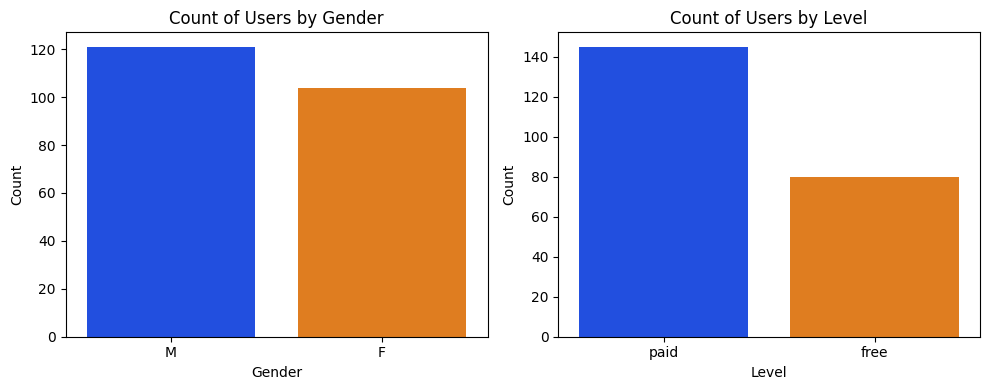

In [17]:
# Group by userId and extract gender and level values
gender_data = df.groupby('userId')['gender'].last().value_counts()
level_data = df.groupby('userId')['level'].last().value_counts()

# Set up the subplot grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot count for gender
gender_labels = gender_data.index.tolist()
sns.barplot(x=gender_labels, y=gender_data.values, ax=axes[0], palette='bright')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].set_title('Count of Users by Gender')

# Plot count for level
level_labels = level_data.index.tolist()
sns.barplot(x=level_labels, y=level_data.values, ax=axes[1], palette='bright')
axes[1].set_xlabel('Level')
axes[1].set_ylabel('Count')
axes[1].set_title('Count of Users by Level')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


####**Location**

The top two locations are Los Angeles-Long Beach-Anaheim, CA and New York-Newark-Jersey City, NY-NJ-PA. Most other locations only had 1 user.

In [18]:
# count for location (top 5)

location_counts = df.drop_duplicates(['userId', 'location'])['location'].value_counts().head().reset_index()
location_counts.columns = ['location', 'Count']

display(pd.DataFrame(location_counts))


,location,Count
0,"Los Angeles-Long Beach-Anaheim, CA",16
1,"New York-Newark-Jersey City, NY-NJ-PA",15
2,"Dallas-Fort Worth-Arlington, TX",7
3,"Phoenix-Mesa-Scottsdale, AZ",7
4,"St. Louis, MO-IL",6


In [65]:
# count for location (bottom 5)

location_counts = df.drop_duplicates(['userId', 'location'])['location'].value_counts().tail().reset_index()
location_counts.columns = ['location', 'Count']

display(pd.DataFrame(location_counts))

,location,Count
0,"Jacksonville, FL",1
1,"Albany-Schenectady-Troy, NY",1
2,"Manchester-Nashua, NH",1
3,"Bozeman, MT",1
4,"Roanoke, VA",1


In [78]:
df['location'] = df['location'].str.split(',').str[-1].str.strip()
df.head()

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,lastName,firstName,registration,gender,songs_per_session,formatted_ts,churn,date,month,day
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,CA,...,Freeman,Colin,1.538173e+12,M,36,2018-10-01 00:01:57,0,2018-10-01,October,Monday
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,MA-NH,...,Long,Micah,1.538332e+12,M,33,2018-10-01 00:03:00,0,2018-10-01,October,Monday
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,CA,...,Freeman,Colin,1.538173e+12,M,36,2018-10-01 00:06:34,0,2018-10-01,October,Monday
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,MA-NH,...,Long,Micah,1.538332e+12,M,33,2018-10-01 00:06:56,0,2018-10-01,October,Monday
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,CA,...,Freeman,Colin,1.538173e+12,M,36,2018-10-01 00:11:16,0,2018-10-01,October,Monday


####**Page**

Next song is the page with the most occurrences which makes sense since the app is a music streaming app. Thumbs up has the next highest count. Error pages are rare. Upgrades/Downgrades and cancellation pages are the least visited pages.

In [19]:
# get a list of unique values in page column

df['page'].unique().tolist()

['NextSong',
 'Add to Playlist',
 'Roll Advert',
 'Thumbs Up',
 'Downgrade',
 'Thumbs Down',
 'Home',
 'Logout',
 'Help',
 'Upgrade',
 'Add Friend',
 'Settings',
 'Submit Upgrade',
 'About',
 'Submit Downgrade',
 'Error',
 'Save Settings',
 'Cancel',
 'Cancellation Confirmation']

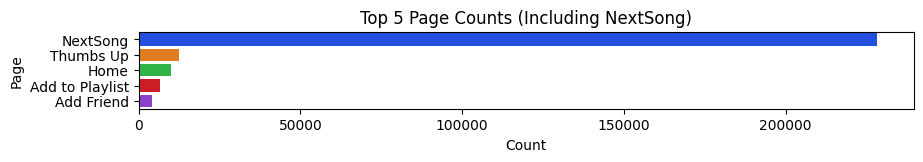

In [20]:
# Top 5 page occurrences including 'NextSong'
page_counts = df["page"].value_counts().reset_index()

# Filter out 'NextSong' if it exists
top_pages = page_counts.head(5)

plt.rcParams['figure.figsize'] = (10, 1)
sns.barplot(x="page", y="index", data=top_pages, palette="bright")
plt.xlabel('Count')
plt.ylabel('Page')
plt.title('Top 5 Page Counts (Including NextSong)')
plt.show()

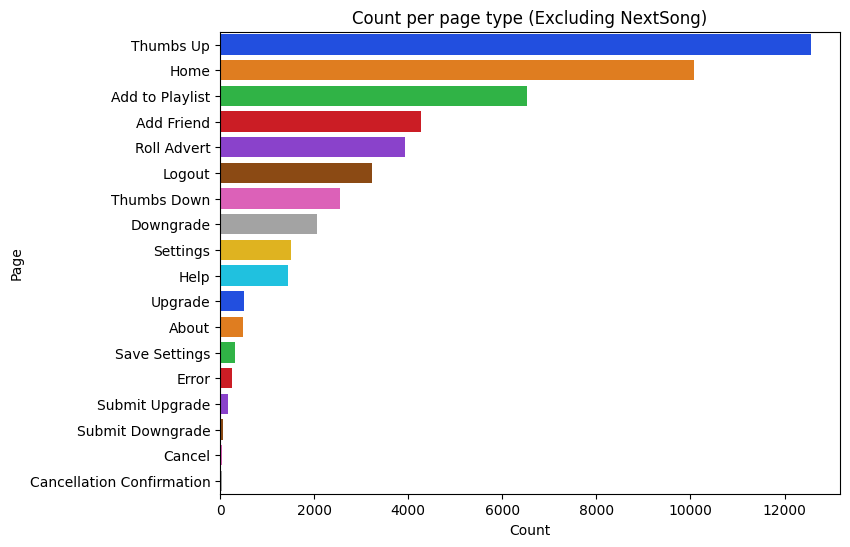

In [21]:
# Exclude 'NextSong' from count
page_counts = df[df["page"] != "NextSong"]["page"].value_counts().reset_index()

plt.rcParams['figure.figsize'] = (8, 6)
sns.barplot(x="page", y="index", data=page_counts, palette="bright")
plt.xlabel('Count')
plt.ylabel('Page')
plt.title('Count per page type (Excluding NextSong)')
plt.show()

#### **auth column**

After cleaning up, there's two user authentication statuses in the dataset: "Logged in" and "Cancelled"

In [67]:
#auth_counts = df["auth"].value_counts().reset_index()
auth_counts = df['auth'].value_counts().reset_index()
auth_counts.columns = ["auth", "Count"]

display(pd.DataFrame(auth_counts))


,auth,Count
0,Logged In,278102
1,Cancelled,52


##**Analyzing features against churn**

######**Churn**
Our sample data has a churn rate of 23.11%

In [23]:
# creating our target column. If page column = 'Cancellation Confirmation' then the customer has cancelled subscription

df['churn'] = np.where(df['page'] == 'Cancellation Confirmation', 1, 0) #1- Customer Churns 0- Customer doesn’t churn


In [28]:
# function to calculate churn rate

def calculate_churn_rate(df):
    churned_users = df[df['churn'] == 1]['userId'].nunique()
    total_users = df['userId'].nunique()
    churn_rate = churned_users / total_users * 100
    
    return f"{churned_users} people churned out of {total_users}. The churn rate is {churn_rate:.2f}%."

In [29]:
result = calculate_churn_rate(df)
print(result)

52 people churned out of 225. The churn rate is 23.11%.


#####**Churn by Gender and Location**

During this period, men churned more than women and paid users churned more than people using the app for free. However there are more men using the app and more paid than free users in the sample data.

In [84]:
def plot_churn_count(data):
    feature_column = input("Enter the feature column name to visualize churn count: ")
    if feature_column not in data.columns:
        print("Specified feature column does not exist in the DataFrame.")
        return
    
    churned_data = data[data['churn'] == 1]  # Filter only churned users
    
    plt.rcParams['figure.figsize'] = (10, 1)
    sns.countplot(y=feature_column, data=churned_data, palette='bright', orient='h')
    plt.xlabel('Count')
    plt.ylabel(feature_column)
    plt.title('Churn Count by {}'.format(feature_column))
    plt.show()


Enter the feature column name to visualize churn count: gender


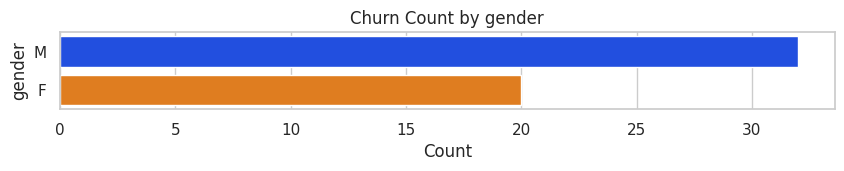

In [31]:
# Churn by gender

plot_churn_count(df)

Enter the feature column name to visualize churn count: level


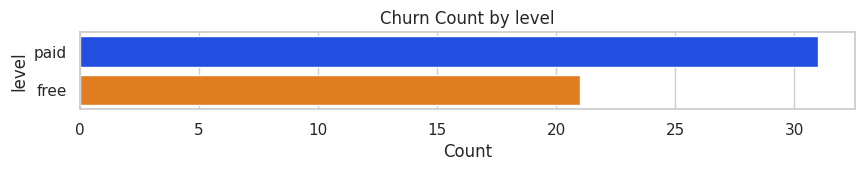

In [85]:
# churn by level

plot_churn_count(df)

#####**Churn by Location**

NY-NJ-PA and CA had the highest churn count. With 5 and 6 people churning, respectively. These are also the locations with the overall highest counts in our dataset.

The New York city and Los Angeles areas had the most people churn during this period.

Enter the feature column name to visualize churn count: location


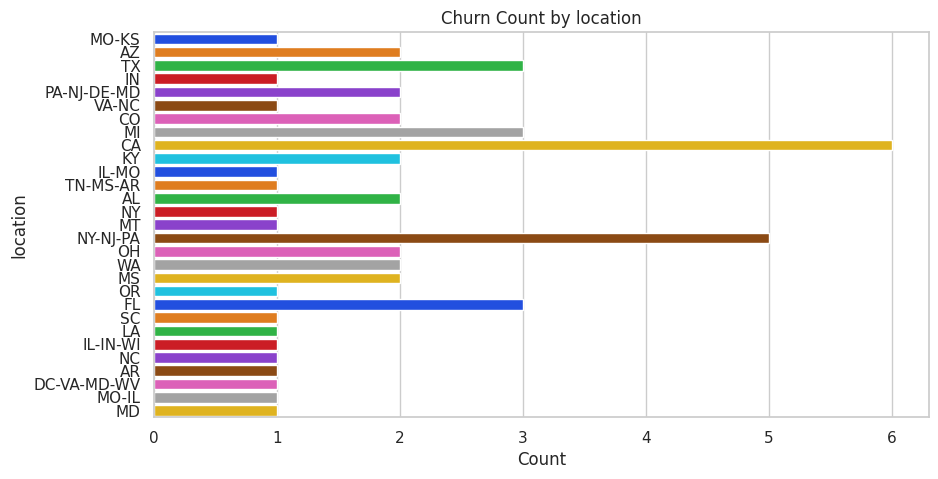

In [86]:
# churn by location
def churn_by_location(data):
    feature_column = input("Enter the feature column name to visualize churn count: ")
    if feature_column not in data.columns:
        print("Specified feature column does not exist in the DataFrame.")
        return
    
    churned_data = data[data['churn'] == 1]  # Filter only churned users
    
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.countplot(y=feature_column, data=churned_data, palette='bright', orient='h')
    plt.xlabel('Count')
    plt.ylabel(feature_column)
    plt.title('Churn Count by {}'.format(feature_column))
    plt.show()

churn_by_location(df)

In [34]:
# churn by location (top 5)

churn_rate_location = df[df['churn'] == 1].groupby(['userId', 'location']).size().reset_index(name='churn_count')
churn_rate_location = churn_rate_location.groupby('location')['churn_count'].count().reset_index(name='churn_users')
top5_locations = churn_rate_location.sort_values('churn_users', ascending=False).head(5).reset_index(drop=True)
top5_locations

,location,churn_users
0,"New York-Newark-Jersey City, NY-NJ-PA",5
1,"Los Angeles-Long Beach-Anaheim, CA",3
2,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2
3,"Flint, MI",2
4,"Miami-Fort Lauderdale-West Palm Beach, FL",2


##### **Date**

In [87]:
#checking datatypes 
df['ts'].dtypes

dtype('int64')

In [36]:
#create a date column, strip time

df['date'] = pd.to_datetime(df['formatted_ts']).dt.date
df.head(4)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,songs_per_session,formatted_ts,churn,date
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,36,2018-10-01 00:01:57,0,2018-10-01
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,33,2018-10-01 00:03:00,0,2018-10-01
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,36,2018-10-01 00:06:34,0,2018-10-01
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,33,2018-10-01 00:06:56,0,2018-10-01


Most people churned in October than in November but November had the highest churn date with 5 people leaving the app on November 2nd. Average number of people who churn in a day is 1.44

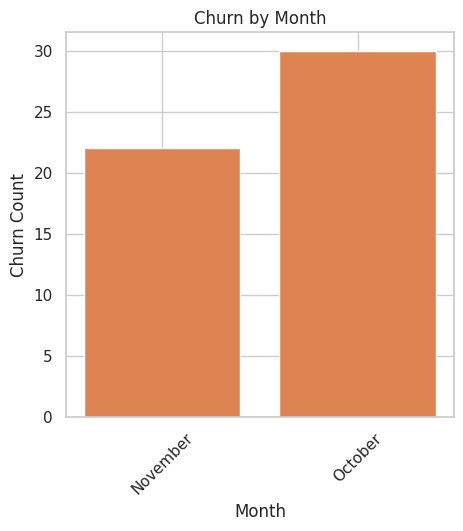

In [38]:
# churn by month

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract month from date
df['month'] = df['date'].dt.strftime('%B')

# Calculate churn by month
churn_by_month = df[df['churn'] == 1].groupby('month').size()

# Set the figure size
plt.figure(figsize=(5, 5))

# Create bar chart with adjusted bar width
bar_width = 0.1  # Adjust the width of the bars as desired
plt.bar(churn_by_month.index, churn_by_month.values, width=bar_width)

# Create bar chart
plt.bar(churn_by_month.index, churn_by_month.values)
plt.xlabel('Month')
plt.ylabel('Churn Count')
plt.title('Churn by Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

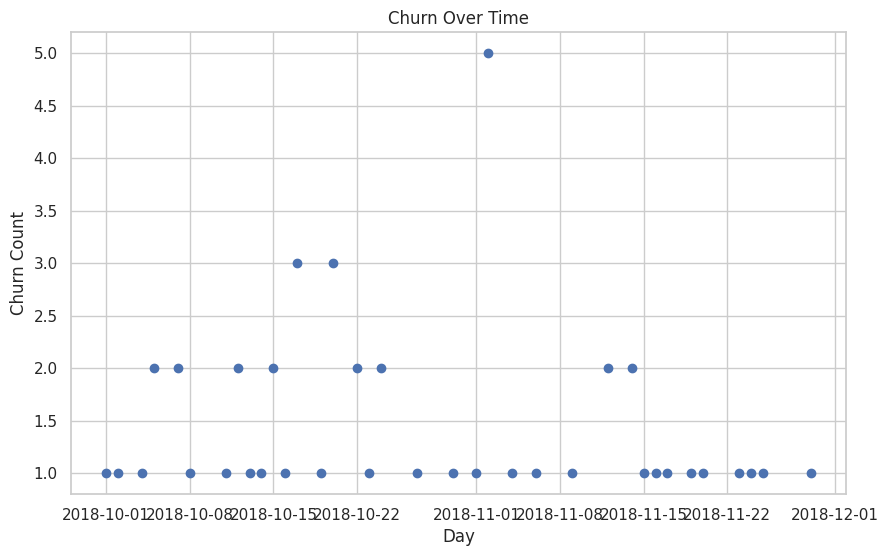

In [57]:
# Extract the day component
df['day'] = df['date'].dt.date

# Group by day and count churned users
churn_count = df[df['churn'] == 1].groupby('day').size()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(churn_count.index, churn_count.values)

# Set labels and title
plt.xlabel('Day')
plt.ylabel('Churn Count')
plt.title('Churn Over Time')

# Show the plot
plt.show()

In [60]:
df['day'] = df['date'].dt.strftime('%A')  # Get the day name

# Group by date and count churned users
churn_count_per_day = df[df['churn'] == 1].groupby('date').size()

# Find the date with the highest churn
max_churn_date = churn_count_per_day.idxmax()
max_churn_day = df[df['date'] == max_churn_date]['day'].iloc[0]

print("Day with the highest churn:")
print("Date:", max_churn_date)
print("Day:", max_churn_day)

Day with the highest churn:
Date: 2018-11-02 00:00:00
Day: Friday


In [58]:
# Group by day and count churned users
churn_count_per_day = df[df['churn'] == 1].groupby('day').size()

# Calculate the average churn count per day
average_churn_per_day = churn_count_per_day.mean()

print("Average number of people who churn in a day:", average_churn_per_day)

Average number of people who churn in a day: 1.4444444444444444


####**Songs per session/session IDs**

In [50]:
# average # of session ids per userID (to see if how frequently someone uses the app affects churn)

churned_users = df[df['churn'] == 1]['userId'].unique()
# Filter the dataframe to include only churned users
churned_data = df[df['userId'].isin(churned_users)].groupby('userId')['sessionId'].nunique()

# data of users who did not churn
not_churned_users = df[~df['userId'].isin(churned_users)]

avg_sessions_churned = churned_data.mean()
avg_sessions_not_churned = not_churned_users.groupby('userId')['sessionId'].nunique().mean()

print("Users who churned used the app an average of {:.2f} session IDs.".format(avg_sessions_churned))
print("Users who did not churn used the app an average of {:.2f} session IDs.".format(avg_sessions_not_churned))


Users who churned used the app an average of 10.33 session IDs.
Users who did not churn used the app an average of 15.25 session IDs.


Most users who churned had less than 13 sessions within the 
timeframe of this dataset, indicating a low level of engagement before churning.

The maximum number of sessions for churned users was approximately 37, while the maximum for active users was over 100, although this was considered an outlier.

The distribution of session counts for active users is skewed towards lower values, indicating that a significant portion of active users had a relatively low number of sessions.

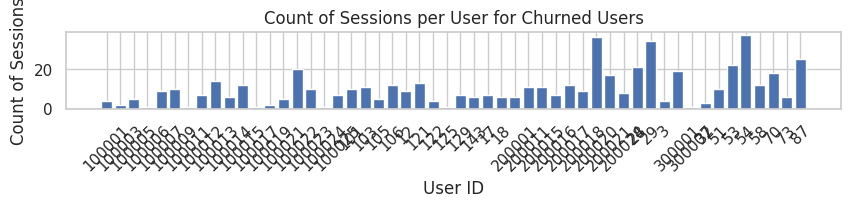

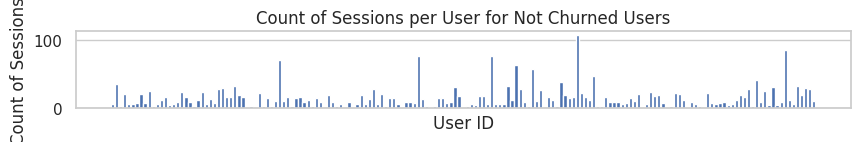

In [51]:
# Calculate count of sessions per user for churned and not churned users
count_sessions_churned = df[df['userId'].isin(churned_users)].groupby('userId')['sessionId'].nunique()
count_sessions_not_churned = df[~df['userId'].isin(churned_users)].groupby('userId')['sessionId'].nunique()

# Plot count of sessions for churned users
plt.bar(count_sessions_churned.index, count_sessions_churned.values)
plt.xlabel('User ID')
plt.ylabel('Count of Sessions')
plt.title('Count of Sessions per User for Churned Users')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Plot count of sessions for not churned users
plt.bar(count_sessions_not_churned.index, count_sessions_not_churned.values)
plt.xlabel('User ID')
plt.ylabel('Count of Sessions')
plt.title('Count of Sessions per User for Not Churned Users')
plt.xticks([])  # Remove the tick marks on the X-axis since they are crowded
plt.show()


**Removing Outliers (users with high number of session counts) to see how that will affect our data.**

In [52]:
# Remove outliers using IQR method for churned users
q1_churned = count_sessions_churned.quantile(0.25)
q3_churned = count_sessions_churned.quantile(0.75)
iqr_churned = q3_churned - q1_churned
lower_bound_churned = q1_churned - 1.5 * iqr_churned
upper_bound_churned = q3_churned + 1.5 * iqr_churned
count_sessions_churned = count_sessions_churned[count_sessions_churned <= upper_bound_churned]

# Remove outliers using IQR method for not churned users
q1_not_churned = count_sessions_not_churned.quantile(0.25)
q3_not_churned = count_sessions_not_churned.quantile(0.75)
iqr_not_churned = q3_not_churned - q1_not_churned
lower_bound_not_churned = q1_not_churned - 1.5 * iqr_not_churned
upper_bound_not_churned = q3_not_churned + 1.5 * iqr_not_churned
count_sessions_not_churned = count_sessions_not_churned[count_sessions_not_churned <= upper_bound_not_churned]

# Calculate the average number of sessions for churned users after removing outliers
avg_sessions_churned = count_sessions_churned.mean()

# Calculate the average number of sessions for not churned users after removing outliers
avg_sessions_not_churned = count_sessions_not_churned.mean()

# Print the results
print("Average number of sessions for users who churned: {:.2f}".format(avg_sessions_churned))
print("Average number of sessions for users who did not churn: {:.2f}".format(avg_sessions_not_churned))


Average number of sessions for users who churned: 8.44
Average number of sessions for users who did not churn: 12.28


Most users had less than 15 sessions for both churn and non churn. Churned users had less sessions overall. Most users who remained active had a count of about 6 sessions and most users who churned had 1 session.

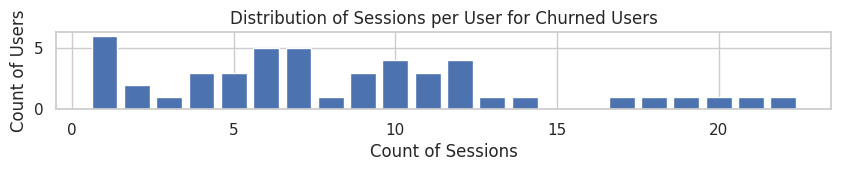

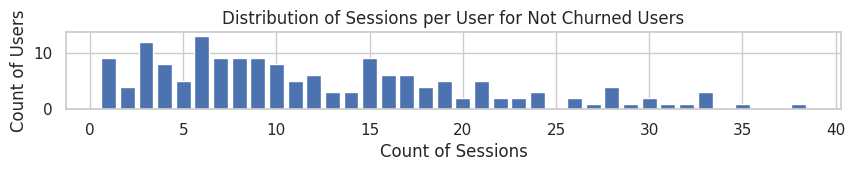

In [53]:
# Calculate count of sessions per user for churned and not churned users
#count_sessions_churned = df[df['userId'].isin(churned_users)].groupby('userId')['sessionId'].nunique()
#count_sessions_not_churned = df[df['churn'] == 0].groupby('userId')['sessionId'].nunique()

# Create aggregated data for bar chart
agg_data_churned = count_sessions_churned.value_counts().sort_index()
agg_data_not_churned = count_sessions_not_churned.value_counts().sort_index()

# Plot bar chart with aggregated data for churned users
plt.bar(agg_data_churned.index, agg_data_churned.values)
plt.xlabel('Count of Sessions')
plt.ylabel('Count of Users')
plt.title('Distribution of Sessions per User for Churned Users')
plt.show()

# Plot bar chart with aggregated data for not churned users
plt.bar(agg_data_not_churned.index, agg_data_not_churned.values)
plt.xlabel('Count of Sessions')
plt.ylabel('Count of Users')
plt.title('Distribution of Sessions per User for Not Churned Users')
plt.show()


##**Conclusions**:

Based on the sample data, the frequency of app usage appears to be a significant indicator of churn. Frequent users tend to have lower churn rates compared to less active users.

The average session count for users who did not churn was 15.25, while users who churned had an average session count of 10.33. This suggests that users who engage with the app more frequently are less likely to churn.

The data indicates that there is a higher proportion of active users compared to users who churned. This implies that the app has a relatively stable user base, but there is room for improvement in reducing churn rates.

The data also reveals that there are more paid users than free users within the sample. This suggests that the app may have a successful monetization strategy, as paid users are more prevalent.

Additionally, the data shows that most days in the sample data had only one user who churned. This could indicate that churn events are relatively sporadic and not widespread.

For machine learning purposes, it would be necessary to normalize the data by applying preprocessing techniques such as scaling or standardization. This normalization step ensures that the data is on a consistent scale and can be effectively used in machine learning algorithms.

Overall, these insights highlight the importance of encouraging frequent app usage, improving user engagement, and implementing strategies to retain users and reduce churn.